In [1]:
# General imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from astropy.io import fits
from astropy.table import Table
import os
os.chdir("/Users/keith/astr/research_astr/roman_grism_sim/ultra_smooth_lambda_dependent/fits")

# Pretty plots
import matplotlib
matplotlib.rcParams["figure.figsize"] = (11,8.5)
matplotlib.rcParams["image.interpolation"] = "nearest"
matplotlib.rcParams["image.origin"] = "lower"

# Grizli
from grizli.model import GrismFLT

# pysynphot
import pysynphot as S

# WebbPSF
import webbpsf
import webbpsf.roman

from scipy.stats import chisquare

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
# Read SED template; using G0V star template
spec = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
src = S.ArraySpectrum(wave=spec["col1"], flux=spec["col2"])

# PSF
wfi = webbpsf.roman.WFI()
# webbpsf.setup_logging("Error")

eff_psf = wfi.calc_psf(monochromatic=(20000 * (10**-10)), fov_pixels=182, oversample=2, source=src)[0].data

psf_direct = np.zeros((4288, 4288))
psf_direct[(2144-182): (2144+182), (2144-182):(2144+182)] = eff_psf

In [3]:
# initialize grizli
pad = 100
roman = GrismFLT(direct_file="empty_direct.fits", seg_file="empty_seg.fits", pad=pad)

# add psf direct image and seg map
roman.direct.data["SCI"] = psf_direct.astype("float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [4]:
# set truth
spec = spec[1770:3771] # truncate spectrum to 10000-20000 angstroms

truth = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, 
                                   store=False, in_place=False, spectrum_1d=[spec["col1"], spec["col2"]])[1]
                                
truth_extraction = np.array([truth[:, ii].sum() for ii in range(truth.shape[1])])

In [5]:
def chunk(start_wave, end_wave):
    start_index = int((start_wave - 10000) / 5)
    end_index = int((end_wave - 10000) / 5) + 1

    chunk_spec = np.asarray(spec[start_index:end_index])

    return chunk_spec

def dispersion_model(pad, nbins, return_input=False, return_extraction=False, return_all=False):

    pad = int(pad) # overlap extent; data points
    nbins = int(nbins) # number of bins

    window_x = np.linspace(0, np.pi, pad)
    front_y = (1-np.cos(window_x)) / 2
    back_y = 1 - front_y

    bins = np.linspace(10000, 20000, nbins + 1)

    piecemeal_sim = np.zeros((4288,4288))

    input_catcher = []
    
    for ii, start_wave in enumerate(bins[:-1]):
        end_wave = bins[ii+1]

        start_wave -= (pad * 5) * 0.5 # times 5 from indicies to wavelength
        end_wave += ((pad - 1) * 5) * 0.5

        if start_wave < 10000:
            start_wave = 10000
        
        if end_wave > 20000:
            end_wave = 20000

        chunk_spec = chunk(start_wave, end_wave) # extract relevant part of spectrum
        wave = chunk_spec["col1"]
        flux = chunk_spec["col2"]

        # apodize
        if start_wave != 10000:
            flux[:pad] *= front_y

        if end_wave != 20000:
            flux[-pad:] *= back_y

        # print("wave range:", wave[0], wave[-1])
        # print("flux range:", flux[0], flux[-1])

        single_dispersion = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77, is_cgs=True, store=False,
                                                       in_place=False, spectrum_1d=[wave, flux])[1]

        piecemeal_sim += single_dispersion

        apodized_spec = Table([wave, flux], names=("wave","flux"))

        input_catcher.append(apodized_spec)

        del chunk_spec
        del flux
        del wave

    piecemeal_extraction = np.array([piecemeal_sim[:, ii].sum() for ii in range(piecemeal_sim.shape[1])])

    if return_input:
        return input_catcher

    if return_extraction:
        return piecemeal_extraction

    if return_all:
        return input_catcher, piecemeal_extraction, piecemeal_sim

    return piecemeal_sim

def combine_overlaps(table_1, table_2):

    full_input = join(table_1, table_2, keys='wave', join_type="outer")

    full_input["flux_1"].fill_value = 0
    full_input["flux_2"].fill_value = 0
    full_input = full_input.filled()

    sum = full_input["flux_1"] + full_input["flux_2"]

    sum_table = Table([full_input["wave"], sum], names=["wave", "flux"])

    return sum_table

In [6]:
# test ranges
pad_range = range(2, 21, 2)
nbin_range = range(10, 101, 10)

In [7]:
chi_image = np.zeros((len(pad_range), len(nbin_range)))

def chi_2d():
    for ii, pad in enumerate(pad_range):
        for jj, nbins in enumerate(nbin_range):
            
            theta = {"pad": pad, "nbins": nbins}

            chi_image[ii, jj] = sum((truth_extraction - dispersion_model(**theta, return_extraction=True))**2)

    return chi_image

def chi_1d(pad_range=pad_range, nbins=100):
    chi_array = []
    for ii, pad in enumerate(pad_range):
        theta = {"pad": pad, "nbins": nbins}

        chi_array.append(sum((truth_extraction - dispersion_model(**theta, return_extraction=True))**2))

    return chi_array

In [8]:
pad_range_1d = np.arange(20, 1000, 2)

chi_vals = chi_1d(pad_range=pad_range_1d, nbins=2)

(20.0, 100.0)

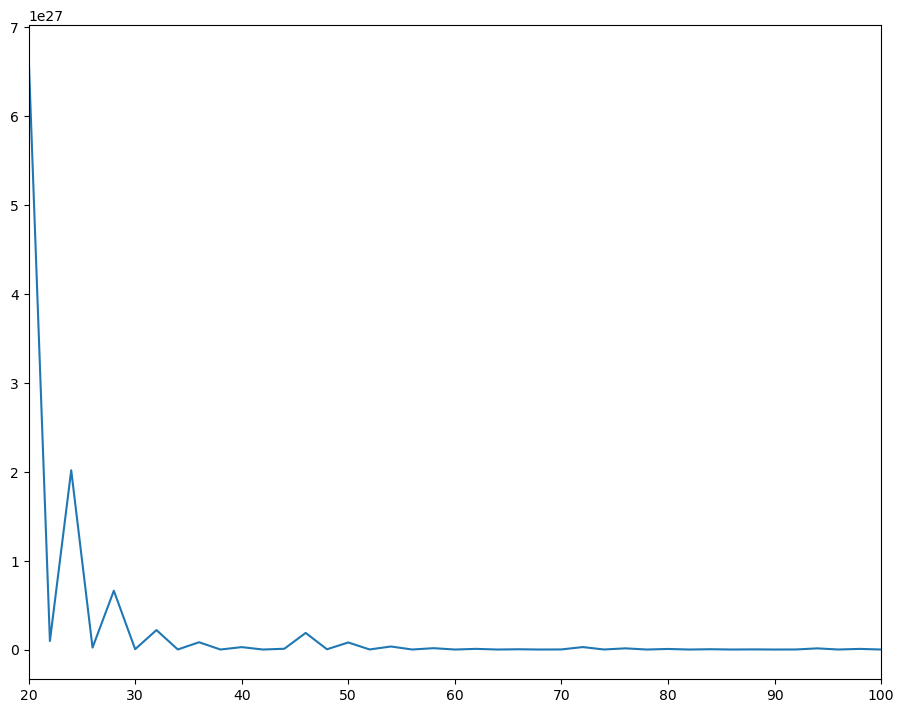

In [11]:
plt.plot(pad_range_1d, chi_vals);
plt.xlim(20, 100)

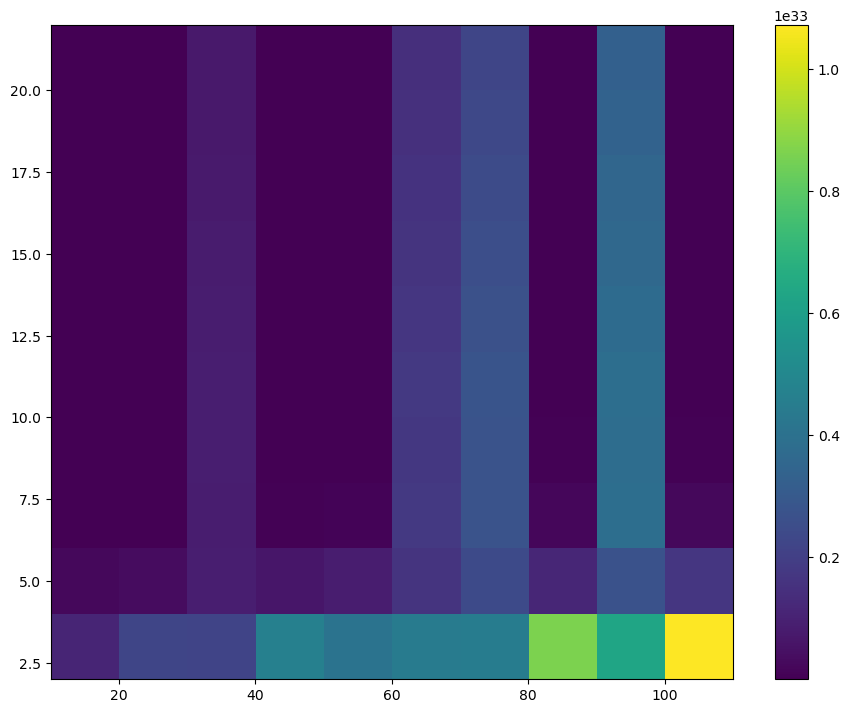

In [10]:
results = chi_2d()

limits = [nbin_range[0], nbin_range[-1] + 10, pad_range[0], pad_range[-1] + 2]

plt.imshow(results, origin="lower", extent=limits, aspect="auto")
plt.colorbar()